# Fitting a line to data: 

## Linear least squares

Tags: Python, numpy, least squares

In [ ]:
import astropy.table as at
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Load the simulated data and true parameters:

In [ ]:
data = at.Table.read("../data/heteroskedastic-1024.ecsv")
true_pars = data.meta["true_pars"]

# Subset the data:
data = data[:32]

n_data = len(data)

data[:5]

x,y,y_err
float64,float64,float64
7.513516534115597,-16.532176111402904,8.862078642576972
3.8276628372725754,-12.13982165847792,2.3245317827256518
8.444577119025206,-36.24361649486185,5.476596098450722
6.671048319653003,-20.145597273357012,2.5301146663773326
0.03595082676414485,5.33911946743247,3.646019021481206


Let's visualize the data:

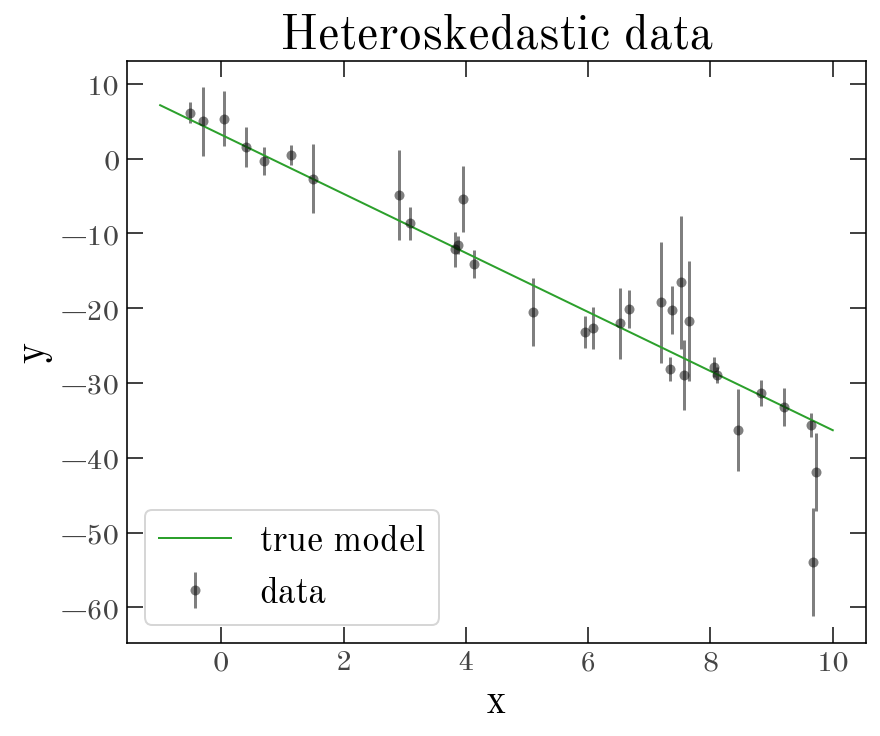

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.errorbar(
    data["x"],
    data["y"],
    yerr=data["y_err"],
    fmt="o",
    color="k",
    alpha=0.5,
    label="data",
)

grid = np.linspace(-1, 10, 128)
ax.plot(
    grid,
    true_pars[0] + true_pars[1] * grid,
    color="tab:green",
    lw=1,
    marker="",
    label="true model",
)
ax.set(xlabel="x", ylabel="y", title="Heteroskedastic data")
ax.legend(loc="lower left", fontsize=18)

## Recipe

Here we assume the data were generated with a linear relation with unknown parameters and no intrinsic scatter, so the only reason an observed data point deviates from this line is because of noise. We assume that this noise process (i.e. the error model) is Gaussian and that the noise (per object) is independent. We assume we know the "x" values perfectly (i.e. with no or vanishingly small uncertainty). Under these assumptions, the data generation process to get the observed value $y_i$ for a single star $i$ with a known value of $x_i$ and uncertainty $\sigma_i$ (only in $y$) is:
$$
y_i = a + b\,x_i + \textrm{noise}
$$
and where the noise is assumed to be drawn from a normal distribution:
$$
\textrm{noise} \sim \mathcal{N}(0, \sigma_i^2)
$$

We can then write the likelihood function for the data in terms of the parameter vector $\boldsymbol{\theta} = (a, b)$ and the model-predicted value of $y$ for a given object, $\tilde{y}_i = a + b\,x_i$:
$$
\begin{align}
p(y_i \,|\, \boldsymbol{\theta}) &= \mathcal{N}(y_i \,|\, \tilde{y}_i, \sigma_i^2) \\
&= \frac{1}{\sqrt{2\pi \,\sigma_i^2}} \exp\left[-\frac{1}{2}\left(\frac{y_i - \tilde{y}_i}{\sigma_i}\right)^2\right]
\end{align}
$$
which is the standard expression for a Gaussian.

If the data are independent, the total likelihood for all data is the product of the individual likelihoods:
$$
p(\{y_i\} \,|\, \boldsymbol{\theta}) = \prod_{i=1}^N p(y_i \,|\, \boldsymbol{\theta})
$$

The maximum likelihood estimate of the parameters is the set of parameters that maximizes this likelihood function. In practice, it is easier to maximize the log likelihood (which is equivalent to maximizing the likelihood, since the log function is monotonic). The log likelihood is:
$$
\log p(\{y_i\} \,|\, \boldsymbol{\theta}) = -\frac{1}{2} \sum_{i=1}^N \left(\log(2\pi) + 2\log(\sigma_i) + \frac{(y_i - \tilde{y}_i)^2}{\sigma_i^2}\right)
$$

If we treat the collection of all data values from all objects as a single vector $\boldsymbol{y} = (y_1, y_2, \dots)$, the collection of all $x$ values as a single vector $\boldsymbol{x}$, and we put the variances (corresponding to the $y$ uncertainties) along the diagonal of a matrix $\mathbf{C}$, we can write the log likelihood in matrix form:
$$
\log p(\boldsymbol{y} \,|\, \boldsymbol{\theta}) = -\frac{1}{2} \left[
    \log(2\pi) + 2\log|\mathbf{C}| + 
    (\boldsymbol{y} - \mathbf{X}\boldsymbol{\theta})^T \, \mathbf{C}^{-1} \,(\boldsymbol{y} - \mathbf{X}\boldsymbol{\theta})
    \right]
$$
where the design matrix $\mathbf{X}$ is a matrix with $N$ rows and 2 columns, where each row looks like is $(1, x_i)$.

To find the maximum of this log likelihood function, set the derivative with respect to $\boldsymbol{\theta}$ to zero and solve for $\boldsymbol{\theta}$. After some algebra, the solution is:
$$
\hat{\boldsymbol{\theta}} = (\mathbf{X}^T \mathbf{C}^{-1} \mathbf{X})^{-1} \, \mathbf{X}^T \mathbf{C}^{-1} \boldsymbol{y}
$$
and the covariance matrix of the parameters around this maximum (i.e. the uncertainties in the parameters) is:
$$
\mathbf{V} = (\mathbf{X}^T \mathbf{C}^{-1} \mathbf{X})^{-1}
$$

We can implement this in Python using `numpy` to handle the matrix algebra.

Create the design matrix:

In [ ]:
X = np.vander(data["x"], 2, increasing=True)
X[:4]  # show the first 4 rows

array([[1.        , 7.51351653],
       [1.        , 3.82766284],
       [1.        , 8.44457712],
       [1.        , 6.67104832]])

We're first going to implement the matrix algebra exactly as written above. But when the uncertainties are uncorrelated (i.e. the matrix $\mathbf{C}$ is diagonal), it is a waste of RAM to create the full matrix $\mathbf{C}$, since we only need the diagonal elements. We will simplify this below, but here we will implement it "naively."

In [ ]:
C = np.diag(data["y_err"] ** 2)
Cinv = np.linalg.inv(C)

In [ ]:
V = np.linalg.inv(X.T @ Cinv @ X)
theta_best1 = V @ X.T @ Cinv @ data["y"]
theta_best1

array([ 4.10111518, -4.10370361])

The diagonal of the parameter covariance matrix tells us variances of the parameter estimates, so the uncertainties in the parameters are the square root of these values:

In [ ]:
np.sqrt(np.diag(V))

array([0.71819467, 0.11642903])

If we compare this to the true values, we can see that our optimized values are consistent within the parameter uncertainties:

In [ ]:
true_pars

[3.1999143760230253, -3.9503943772414374]

We mentioned above that we can make the parameter calculation more efficient when the uncertainties are uncorrelated. In this case, the matrix $\mathbf{C}$ is diagonal, so we have a few options.

- Option 1: use a sparse array, e.g., `scipy.sparse.bsr_array`
- Option 2: rewrite the matrix algebra to avoid creating the full matrix $\mathbf{C}$

We won't talk about option 1, but we can implement option 2 using `numpy.einsum`. This function allows us to write matrix algebra expressions using summation notation. 

In [ ]:
inv_var = 1 / data["y_err"] ** 2
Vinv = np.einsum("ij,j,jk->ik", X.T, inv_var, X)
theta_best2 = np.linalg.inv(Vinv) @ X.T @ (inv_var * data["y"])
theta_best2

array([ 4.10111518, -4.10370361])

One last note is that for problems with many data points, or high dynamic range among the parameter constraints, or highly correlated parameter constraints, it is sometimes numerically unstable to explicitly invert the matrix $\mathbf{X}^T \mathbf{C}^{-1} \mathbf{X}$. In this case, it is better to use a linear solver to solve for $\boldsymbol{\theta}$ without computing the inverse. If we rearrange the least squares solution equation above:
$$
\hat{\boldsymbol{\theta}} = (\mathbf{X}^T \mathbf{C}^{-1} \mathbf{X})^{-1} \, \mathbf{X}^T \mathbf{C}^{-1} \boldsymbol{y}
$$
we can instead write this as:
$$
\mathbf{X}^T \mathbf{C}^{-1} \mathbf{X} \, \hat{\boldsymbol{\theta}} = \mathbf{X}^T \mathbf{C}^{-1} \boldsymbol{y}
$$
which has the standard form of a linear algebra expression:
$$
\mathbf{A} \, \hat{\boldsymbol{\theta}} = \boldsymbol{b}
$$

For problems in this form, we can use `numpy.linalg.solve` instead:

In [ ]:
theta_best3 = np.linalg.solve(X.T @ Cinv @ X, X.T @ Cinv @ data["y"])
theta_best3

array([ 4.10111518, -4.10370361])